## Compute Tidal Height Correction for a given for a given lat,lon,time

In [1]:
# - Import Python  Dependencies
from __future__ import print_function
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
# - pyTMD
from pyTMD.read_tide_model import extract_tidal_constants
from pyTMD.infer_minor_corrections import infer_minor_corrections
from pyTMD.predict_tide import predict_tide
from pyTMD.read_FES_model import extract_FES_constants

## Processing Parameters

In [2]:
# - Absolute path to data directory
data_dir = os.path.join('/', 'Volumes', 'Extreme Pro')  # - NEED TO EDIT

# - Output Directory
out_dir = os.path.join(os.path.expanduser('~'), 'Desktop')  # - NEED TO EDIT

# - Processing Parameters
model = 'CATS2008'      # - CATS2008 or FES2014
date = '2020/10/10'

# - Variable to Read
var_type = 'z'
# - Processing Parameters
date_str = date.split('/')
year = int(date_str[0])
month = int(date_str[1])
day = int(date_str[2])

# - Other Parameters
n_sec_x_day = 24.*60.*60.

## Sample Point Coordinates

In [3]:
# - Sample Point Coordinates
pt_lat = -66.68
pt_lon = 140.05

In [4]:
# - Calculate Number of days relative to Jan 1, 1992 (48622 MJD)
# - using datetime
t_jd_ref = datetime.datetime(year=1992, month=1, day=1, hour=0)
t_est_tide = [datetime.datetime(year=year, month=month, day=day,
                                hour=t) for t in range(0, 24)]

# - Compute Datetime Values for the 24 Hours of the selected date.
delta_time = [(t - t_jd_ref).total_seconds()/n_sec_x_day for t in t_est_tide]

## Compute Tide Height for the seleted Date

In [5]:
# - Compute Tidal Correction
int_time = datetime.datetime.now()      # - Measure Computation time
tidal_cycle = []

if model == 'CATS2008':
    # - Define path to CATS2008 data - NEED TO EDIT
    tide_dir = os.path.join(data_dir, 'cats2008_tmd')
    grid_file = os.path.join(tide_dir, 'grid_CATS2008')
    model_file = os.path.join(tide_dir, 'hf.CATS2008.out')
    # - pyTDM parameters
    model_format = 'OTIS'
    epsg_code = 'CATS2008'
    # -- read tidal constants and interpolate to grid points
    # model_format in ('OTIS','ATLAS'):
    amp, ph, d, c = extract_tidal_constants(pt_lon, pt_lat, grid_file,
                                            model_file, epsg_code,
                                            TYPE=var_type,
                                            METHOD='spline',
                                            GRID=model_format)
    # -- calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # -- calculate constituent oscillation
    hc = amp * np.exp(cph)

    # - tidal cycle
    tidal_cycle = []
    for h in range(24):
        # -- predict tidal elevations at time and infer minor corrections
        tide_p = predict_tide(delta_time[h], hc, c, DELTAT=0,
                              CORRECTIONS=model_format)
        minor_p = infer_minor_corrections(delta_time[h], hc, c,
                                          DELTAT=0,
                                          CORRECTIONS=model_format)
        print(f'# - Time: {h} - Tide Elevation in meters: {tide_p+minor_p}')
        tidal_cycle.append(tide_p+minor_p)

elif model == 'FES2014':
    # - Define path to FES2014 data  - NEED TO EDIT
    model_directory = os.path.join(data_dir, 'AVISO',
                                   'fes2014_elevations_and_load',
                                   'fes2014b_elevations',
                                   'ocean_tide')

    model_files = ['2n2.nc', 'eps2.nc', 'j1.nc', 'k1.nc',
                   'k2.nc', 'l2.nc', 'la2.nc', 'm2.nc', 'm3.nc', 'm4.nc',
                   'm6.nc', 'm8.nc', 'mf.nc', 'mks2.nc', 'mm.nc',
                   'mn4.nc', 'ms4.nc', 'msf.nc', 'msqm.nc', 'mtm.nc',
                   'mu2.nc', 'n2.nc', 'n4.nc', 'nu2.nc', 'o1.nc', 'p1.nc',
                   'q1.nc', 'r2.nc', 's1.nc', 's2.nc', 's4.nc', 'sa.nc',
                   'ssa.nc', 't2.nc']
    model_file = [os.path.join(model_directory, x) for x in model_files]
    model_version = 'FES2014'
    model_format = 'FES'
    model_type = 'z'
    model_scale = 1.0/100.0

    amp, ph = extract_FES_constants(pt_lon, pt_lat,
                                    model_file, TYPE=model_type,
                                    VERSION=model_version,
                                    METHOD='spline', EXTRAPOLATE=False,
                                    CUTOFF=None,
                                    SCALE=model_scale, GZIP=False)
    # -- available model constituents
    c = ['2n2', 'eps2', 'j1', 'k1', 'k2', 'l2',
         'lambda2', 'm2', 'm3', 'm4', 'm6', 'm8', 'mf', 'mks2', 'mm',
         'mn4', 'ms4', 'msf', 'msqm', 'mtm', 'mu2', 'n2', 'n4', 'nu2',
         'o1', 'p1', 'q1', 'r2', 's1', 's2', 's4', 'sa', 'ssa', 't2']

    # -- calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # -- calculate constituent oscillation
    hc = amp * np.exp(cph)

    # - tidal cycle
    tidal_cycle = []
    for h in range(24):
        # -- predict tidal elevations at time and infer minor corrections
        tide_p = predict_tide(delta_time[h], hc, c, DELTAT=0,
                              CORRECTIONS=model_format)
        minor_p = infer_minor_corrections(delta_time[h], hc, c,
                                          DELTAT=0,
                                          CORRECTIONS=model_format)
        print(f'# - Time: {h} - Tide Elevation in meters: '
              f'{ tide_p+minor_p[0]}')
        tidal_cycle.append(tide_p+minor_p)

    int_time_2 = datetime.datetime.now()
    print(f"\n# - Computation Time - FES2014: {int_time_2 - int_time}")

# - Time: 0 - Tide Elevation in meters: [0.07123420934248643]
# - Time: 1 - Tide Elevation in meters: [-0.00802606232276636]
# - Time: 2 - Tide Elevation in meters: [-0.05882280141999809]
# - Time: 3 - Tide Elevation in meters: [-0.09121551532981356]
# - Time: 4 - Tide Elevation in meters: [-0.11927247550782984]
# - Time: 5 - Tide Elevation in meters: [-0.1560180677296059]
# - Time: 6 - Tide Elevation in meters: [-0.20892853674420167]
# - Time: 7 - Tide Elevation in meters: [-0.2771759888963532]
# - Time: 8 - Tide Elevation in meters: [-0.35131948036665367]
# - Time: 9 - Tide Elevation in meters: [-0.41547845904278713]
# - Time: 10 - Tide Elevation in meters: [-0.4513747007152496]
# - Time: 11 - Tide Elevation in meters: [-0.4431604119563977]
# - Time: 12 - Tide Elevation in meters: [-0.3817754749286574]
# - Time: 13 - Tide Elevation in meters: [-0.26772895682886516]
# - Time: 14 - Tide Elevation in meters: [-0.11162696282062534]
# - Time: 15 - Tide Elevation in meters: [0.067649352056

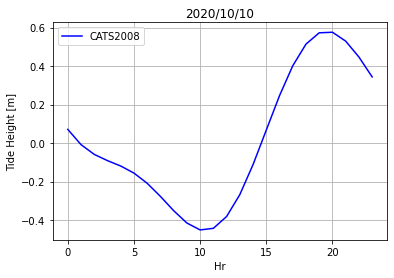

In [6]:
# - Plot the Computed Daily tidal correction
plt.figure()
plt.plot(np.arange(24), tidal_cycle, color='b', label=model)
plt.xlabel('Hr')
plt.ylabel('Tide Height [m]')
plt.grid()
plt.legend()
plt.title(date)
plt.show()

In [7]:
# - Save the Computed Daily Correction
with open(os.path.join(out_dir, model+f'_tide_height[m]_LON={pt_lon}_LAT={pt_lat}_{month}-{day}-{year}.txt'), 'w', encoding='utf8') as w_fid:
    print('Date'.ljust(25)+'Tide Height [m]', file=w_fid)
    for cnt, dt in enumerate(t_est_tide):
        print(f'{datetime.datetime.strftime(dt, "%d/%m/%Y %H:%M:%S"):25}{tidal_cycle[cnt][0]}', file=w_fid)